In [38]:
import random

import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 10)

[[-7.01596585 -2.2139477 ]
 [-8.51715877 -4.20478406]
 [-7.4815656  -3.62620421]
 [-7.45344059 -3.31603294]
 [-5.1718117  -2.38802502]
 [-4.3922231  -0.98843262]
 [-3.7729333  -1.30095491]
 [-5.98626641 -1.38670553]
 [-4.3791461   0.46883314]
 [-2.32266783 -0.47887514]
 [-4.29996565 -1.71422369]
 [-2.55025826  1.18727662]
 [-1.64864701 -1.0228449 ]
 [-1.80754332 -0.1459676 ]
 [-0.56296464  1.67639629]
 [-0.17374968  0.03204461]
 [ 0.87038299  1.98863305]
 [ 1.84285388  1.23857381]
 [ 1.29275203  1.88264959]
 [ 2.19136504  3.3167806 ]
 [ 3.80969595  3.89843435]
 [ 3.88964035  1.57288181]
 [ 3.36897932  2.8871014 ]
 [ 5.05026424  3.89542527]
 [ 5.4904906   4.67570061]
 [ 4.99062258  4.29719266]
 [ 5.3542848   4.90175753]
 [ 6.21962475  5.59500775]
 [ 8.05664539  5.00954528]
 [ 6.44115876  5.53005525]]


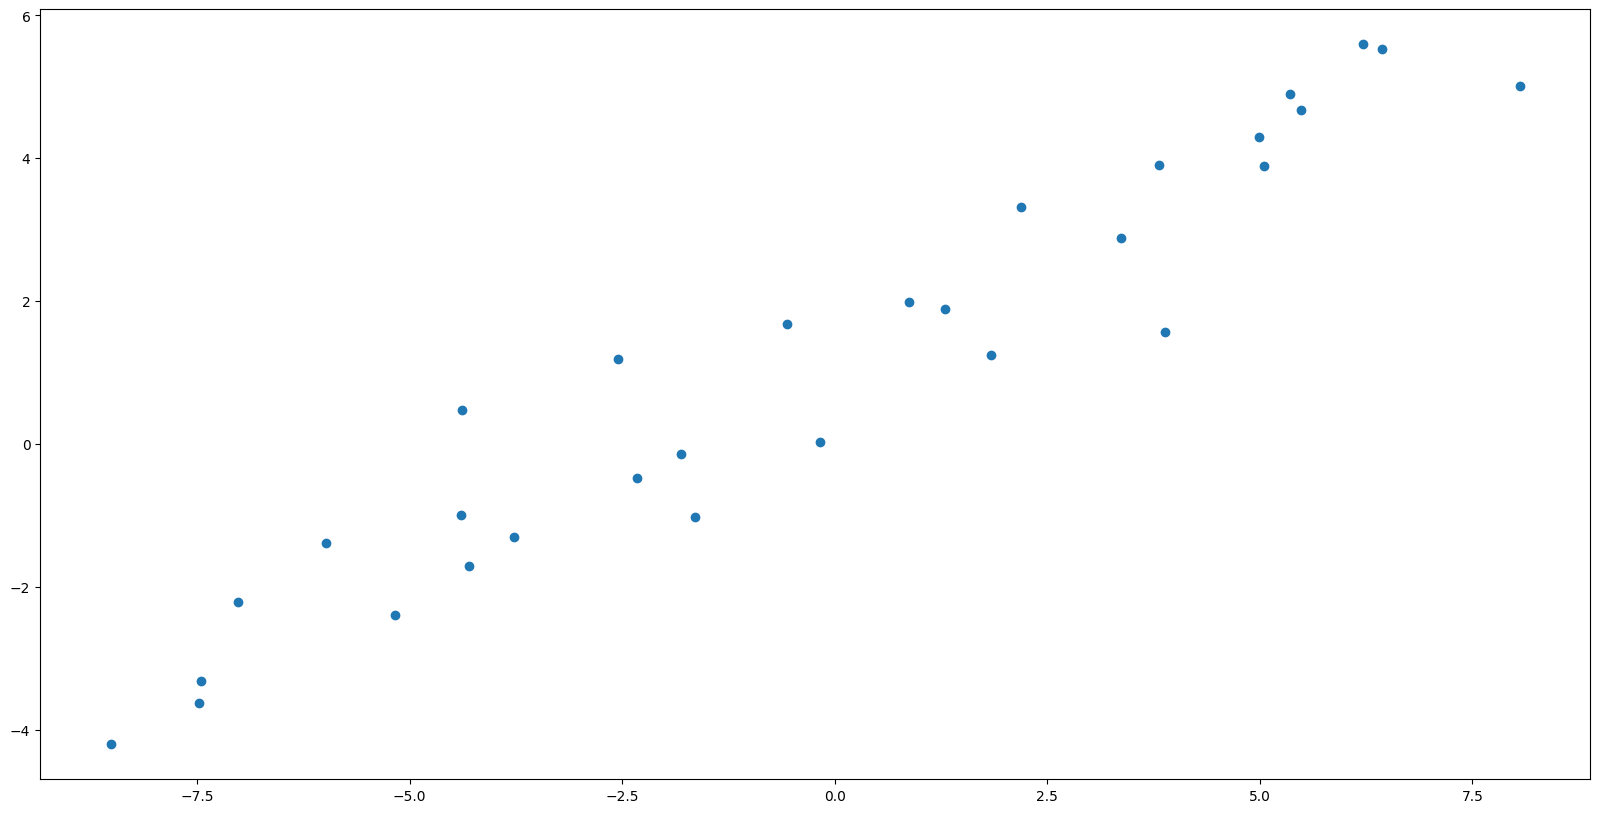

In [39]:
data = np.load('linear_data.npy')
data_size = len(data)
all_indexes = range(data_size)
w_0 = torch.tensor(data[:, 0])
w_1 = torch.tensor(data[:, 1])
iterations_torch = 0
iterations_custom = 0

print(data)
plt.plot(data[:, 0], data[:, 1], 'o')
plt.show()

In [40]:
def tabl(method_name, start_point, iter, points, point_result):
    dat = [[method_name[0], start_point, iter[0], points[0], point_result],
           [method_name[1], start_point, iter[1], points[1], point_result]]
    df = pd.DataFrame(dat, columns=["Method", "Start point", "Iterations", "Result", "Expected"])
    pd.options.display.expand_frame_repr = False
    pd.set_option('colheader_justify', 'center')
    print(df)

Минимизируемая Функция

In [41]:
def f(point, indexes=all_indexes):
    res = 0
    for i in indexes:
        res += (point[0] * data[i][0] + point[1] - data[i][1]) ** 2
    return res

Численное дифференцирование

In [42]:
def num_diff(point, diff_coordinate, indexes, delta=1e-3):
    plus_delta = point.copy()
    plus_delta[diff_coordinate] += delta
    minus_delta = point.copy()
    minus_delta[diff_coordinate] -= delta
    return (f(plus_delta, indexes) - f(minus_delta, indexes)) / (2 * delta)


def grad(point, batch=data_size):
    indexes = random.sample(range(0, data_size), batch)
    return np.array([num_diff(point, i, indexes) for i in range(len(point))])

Условие остановки

In [43]:
def stop(point1, point2, delta=1e-4):
    return np.linalg.norm(point1 - point2, len(point1)) < delta

SGD

In [44]:
def sgd(start, lr, max_epoch, batch=1, delta=1e-3):
    points = np.zeros((max_epoch, len(start)))
    points[0] = start
    point = start.copy()
    loss_list = list()

    i = 1
    while i < max_epoch:
        global iterations_custom
        iterations_custom += 1
        yhat = point[1] + point[0] * w_0
        error = w_1 - yhat
        loss = (error ** 2).mean()
        loss_list.append(loss.data)

        point = point - lr * grad(point, batch)
        points[i] = point
        if stop(points[i], points[i - 1]):
            break
        i += 1

    return points[:i], loss_list

Рисует графики для линейной регрессии

In [164]:
start_point = [-1., -1.]
min_result = [0.5, 1]
max_epoch = 1000

In [165]:
points, loss_list_sgd = sgd(start_point, 0.001, max_epoch, batch=30)

PyTorch SGD

In [166]:
a = torch.tensor([start_point[0]], requires_grad=True)
b = torch.tensor([start_point[1]], requires_grad=True)
iterations_torch = 0

optimizer = optim.SGD([a, b], lr=0.02)

loss_list_torch_sgd = list()
grads_list = list()

for epoch in range(max_epoch):
    global iterations_torch
    iterations_torch += 1

    p1 = [b.item(), a.item()]

    yhat = a + b * w_0
    error = w_1 - yhat
    loss = (error ** 2).mean()
    loss_list_torch_sgd.append(loss.data)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    p2 = [b.item(), a.item()]

    if stop(np.array(p1), np.array(p2)):
        break

result = [b.item(), a.item()]

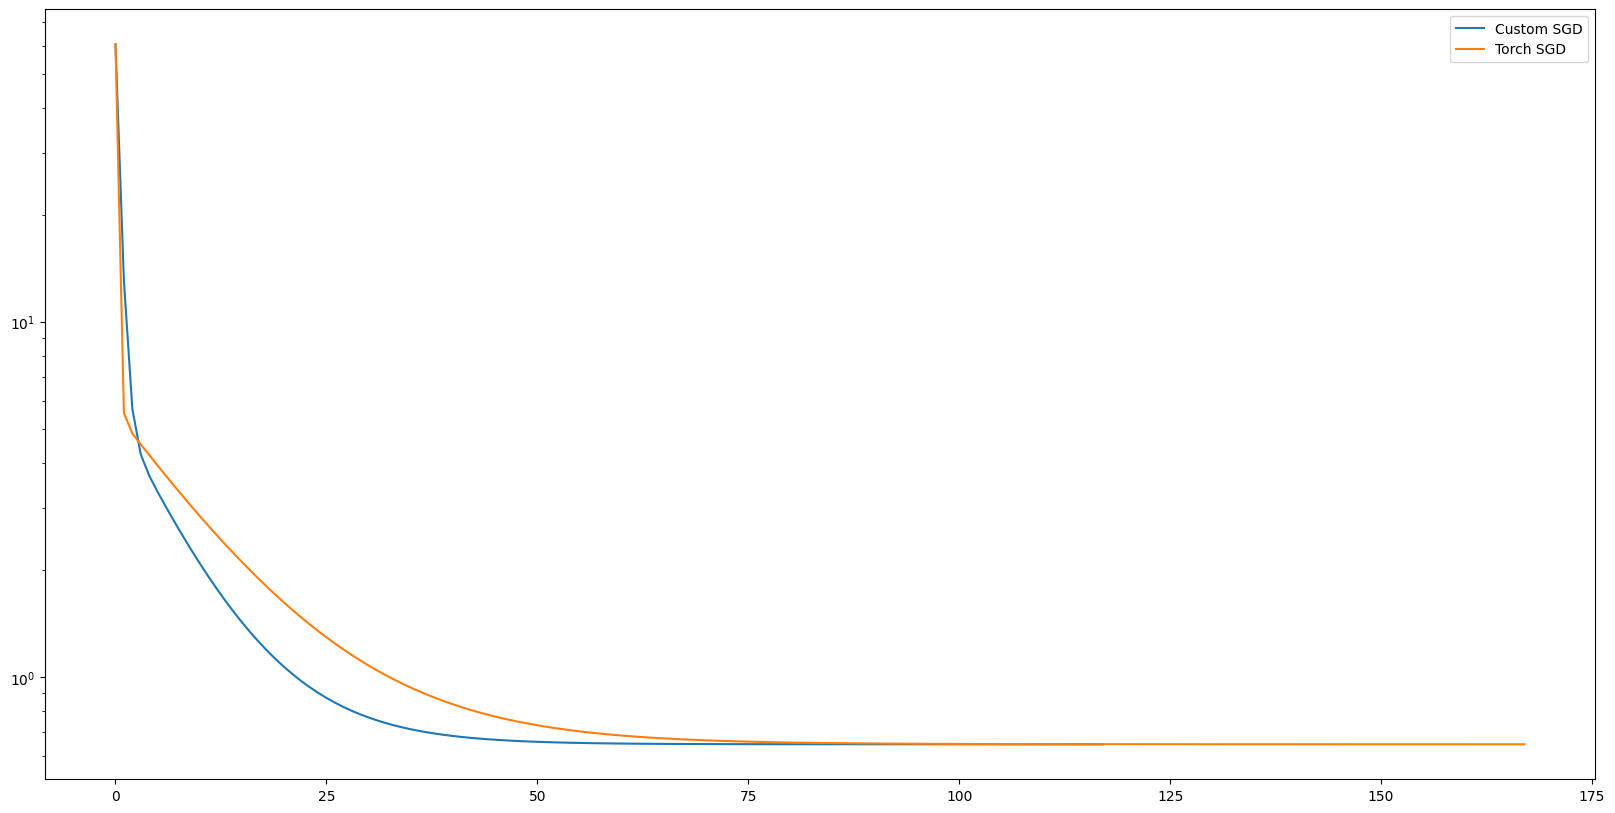

In [167]:
plt.plot(range(len(loss_list_sgd)), loss_list_sgd, label='Custom SGD')
plt.plot(range(len(loss_list_torch_sgd)), loss_list_torch_sgd, label='Torch SGD')
plt.yscale('log')
plt.legend()

In [168]:
tabl(['Custom SGD', 'Torch SGD'], start_point, [iterations_custom, iterations_torch], [points[-1], result], min_result)

     Method    Start point   Iterations                   Result                   Expected
0  Custom SGD  [-1.0, -1.0]      254     [0.5731494051296799, 1.2061975769035218]  [0.5, 1]
1   Torch SGD  [-1.0, -1.0]      168      [0.5731394290924072, 1.205438256263733]  [0.5, 1]


## Вывод:
По графику можно заметить, что функция из библиотеки сходится быстрее, это происходит из-за того, что градиент в SGD из PyTorch вычисляется по методу Autograd, который показывает себя лучше, чем обычное численное дифференцирование, реализованное в SGD из второй лабораторной.

Momentum

In [169]:
def sgd_momentum(start, lr, max_epoch, batch=30, delta=1e-3, gamma=0.9):
    points = np.zeros((max_epoch, len(start)))
    points[0] = start
    v_prev = np.array([0, 0])
    point = start.copy()
    loss_list = list()

    i = 1
    while i < max_epoch:
        global iterations_custom
        iterations_custom += 1

        yhat = point[1] + point[0] * w_0
        error = w_1 - yhat
        loss = (error ** 2).mean()
        loss_list.append(loss.data)

        v_curr = gamma * v_prev + (1 - gamma) * grad(point, batch)
        point = point - lr * v_curr
        v_prev = v_curr
        points[i] = point
        if stop(points[i], points[i - 1]):
            break
        i += 1

    return points[:i], loss_list

PyTorch Momentum

In [170]:
a = torch.tensor([start_point[0]], requires_grad=True)
b = torch.tensor([start_point[1]], requires_grad=True)
iterations_torch = 0

optimizer = optim.SGD([a, b], lr=0.02, momentum=0.9)

loss_list_torch_momentum = list()
grads_list = list()

for epoch in range(max_epoch):
    global iterations_torch
    iterations_torch += 1

    p1 = [b.item(), a.item()]

    yhat = a + b * w_0
    error = w_1 - yhat
    loss = (error ** 2).mean()
    loss_list_torch_momentum.append(loss.data)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    p2 = [b.item(), a.item()]

    if stop(np.array(p1), np.array(p2)):
        break

result = [b.item(), a.item()]

In [171]:
iterations_custom = 0
points, loss_list_momentum = sgd_momentum(start_point, 0.01, max_epoch=max_epoch)

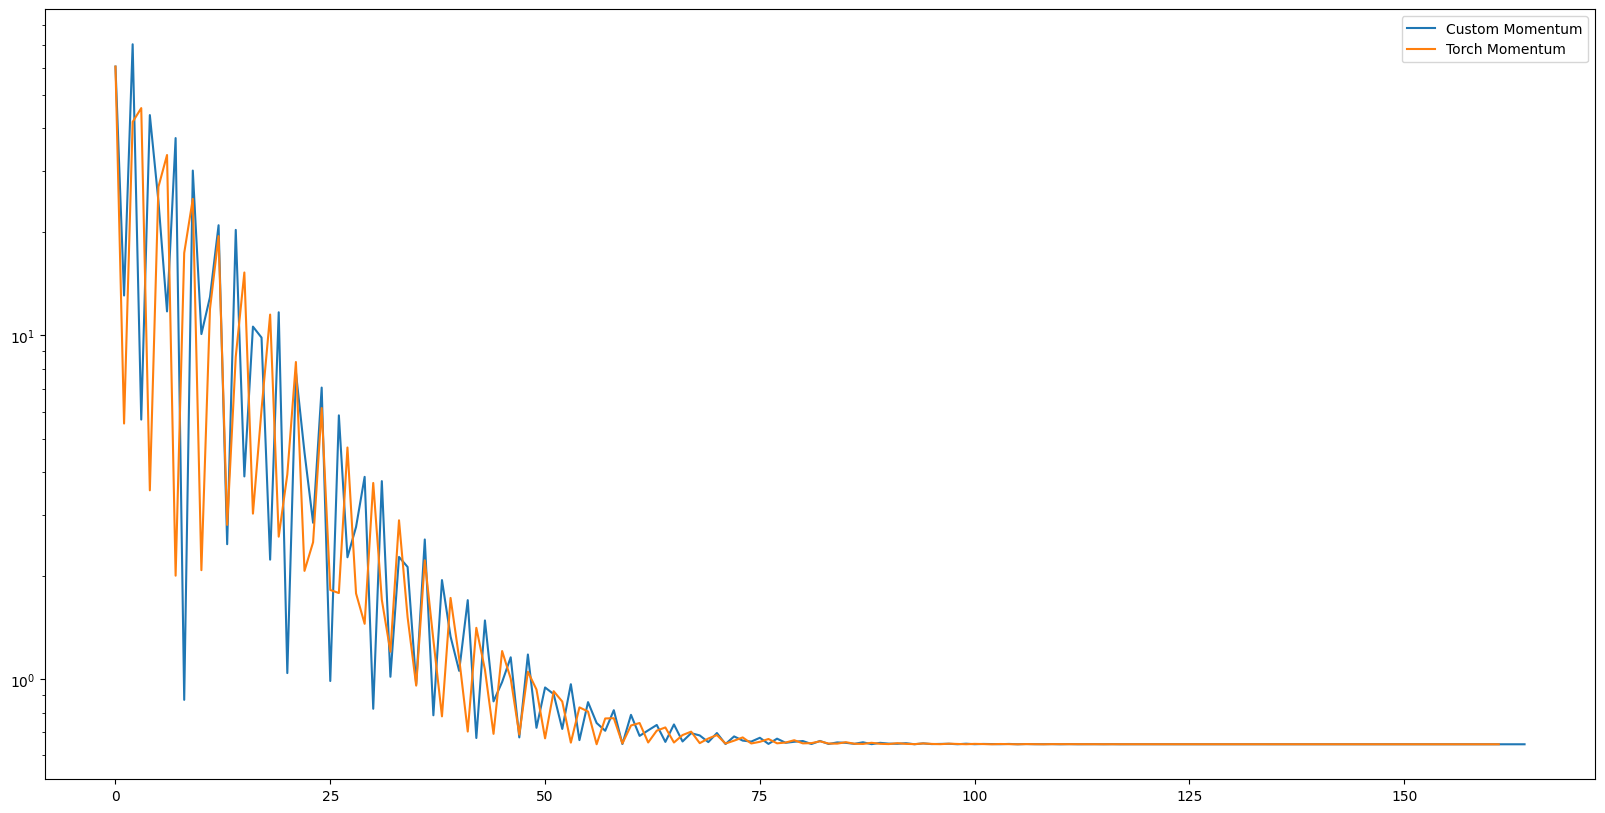

In [172]:
plt.plot(range(len(loss_list_momentum)), loss_list_momentum, label='Custom Momentum')
plt.plot(range(len(loss_list_torch_momentum)), loss_list_torch_momentum, label='Torch Momentum')
plt.yscale('log')
plt.legend()

In [173]:
tabl(['Custom Momentum', 'Torch Momentum'], start_point, [iterations_custom, iterations_torch], [points[-1], result],
     min_result)

       Method       Start point   Iterations                   Result                   Expected
0  Custom Momentum  [-1.0, -1.0]      165     [0.5729184491654954, 1.2081776152880719]  [0.5, 1]
1   Torch Momentum  [-1.0, -1.0]      162     [0.5734299421310425, 1.2074638605117798]  [0.5, 1]


## Вывод:
Можно заметить, что эти 2 метода сошлись почти с одинаковой скоростью, даже несмотря на разные способы вычисления градиента, при этом найденный минимум тоже почти идеально совпадает, это скорее всего результат действия сглаживания от метода скользящего среднего.

In [232]:
def sgd_nesterov(start, lr, max_epoch, batch=30, delta=1e-3, gamma=0.9):
    points = np.zeros((max_epoch, len(start)))
    points[0] = start
    v_prev = np.array([0, 0])
    point = start.copy()
    loss_list = list()

    i = 1
    while i < max_epoch:
        global iterations_custom
        iterations_custom += 1

        yhat = point[1] + point[0] * w_0
        error = w_1 - yhat
        loss = (error ** 2).mean()
        loss_list.append(loss.data)

        g = grad(point - lr * gamma * v_prev, batch)
        v_curr = gamma * v_prev + (1 - gamma) * g
        point = point - lr * v_curr
        v_prev = v_curr
        points[i] = point
        if stop(points[i], points[i - 1]):
            break
        i += 1

    return points[:i], loss_list

In [233]:
a = torch.tensor([start_point[0]], requires_grad=True)
b = torch.tensor([start_point[1]], requires_grad=True)
iterations_torch = 0

optimizer = optim.SGD([a, b], lr=0.001, momentum=0.9, nesterov=True)

loss_list_torch_nesterov = list()
grads_list = list()

for epoch in range(max_epoch):
    global iterations_torch
    iterations_torch += 1

    p1 = [b.item(), a.item()]

    yhat = a + b * w_0
    error = w_1 - yhat
    loss = (error ** 2).mean()
    loss_list_torch_nesterov.append(loss.data)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    p2 = [b.item(), a.item()]

    if stop(np.array(p1), np.array(p2)):
        break

result = [b.item(), a.item()]

In [234]:
iterations_custom = 0
points, loss_list_nesterov = sgd_nesterov(start_point, 0.001, max_epoch=max_epoch)

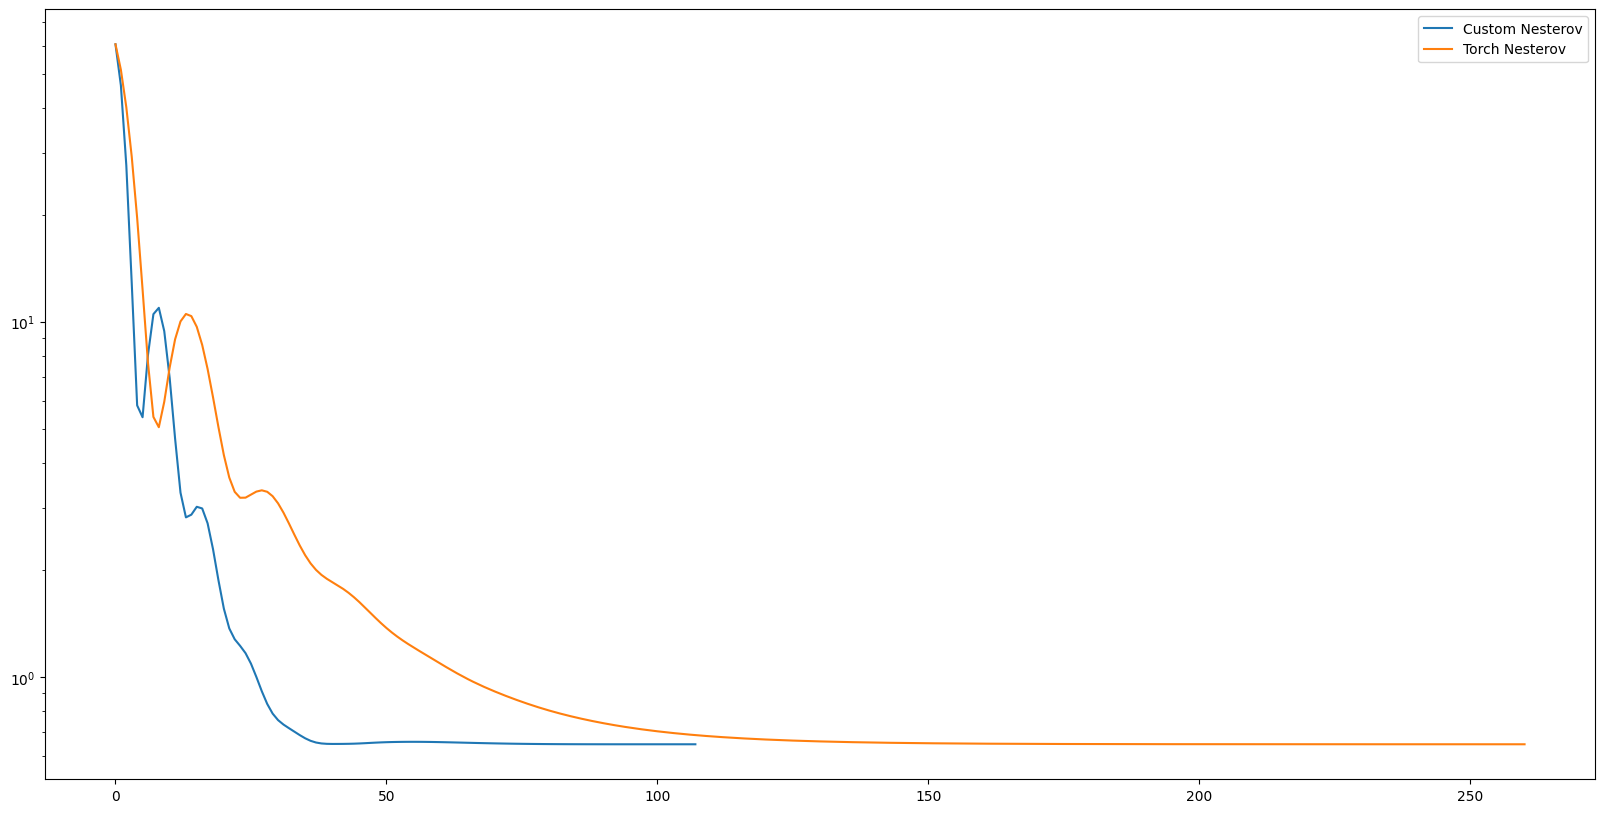

In [235]:
plt.plot(range(len(loss_list_nesterov)), loss_list_nesterov, label='Custom Nesterov')
plt.plot(range(len(loss_list_torch_nesterov)), loss_list_torch_nesterov, label='Torch Nesterov')
plt.yscale('log')
plt.legend()

In [236]:
tabl(['Custom Nesterov', 'Torch Nesterov'], start_point, [iterations_custom, iterations_torch], [points[-1], result],
     min_result)

       Method       Start point   Iterations                   Result                   Expected
0  Custom Nesterov  [-1.0, -1.0]      108      [0.5731134676136806, 1.203331839820583]  [0.5, 1]
1   Torch Nesterov  [-1.0, -1.0]      261     [0.5731214284896851, 1.2040640115737915]  [0.5, 1]


## Вывод
Как ни удивительно, в этом случае наша реализация обогнала по скорости сходимости библиотечную, однако минимум, найденный с помощью PyTorch несколько лучше, чем тот, что найден с помощью кастомной реализации.

In [237]:
def sgd_adagrad(start, lr, max_epoch, batch=30, delta=1e-6, eps=1e-8):
    points = np.zeros((max_epoch, len(start)))
    G = np.array([0, 0])
    points[0] = start
    point = start.copy()
    loss_list = list()

    i = 1
    while i < max_epoch:
        global iterations_custom
        iterations_custom += 1

        yhat = point[1] + point[0] * w_0
        error = w_1 - yhat
        loss = (error ** 2).mean()
        loss_list.append(loss.data)

        g = grad(point, batch)
        G = G + np.power(g, 2)
        point = point - lr / np.power(G + eps, 0.5) * g
        points[i] = point
        if stop(points[i], points[i - 1]):
            break
        i += 1

    return points[:i], loss_list

In [238]:
a = torch.tensor([start_point[0]], requires_grad=True)
b = torch.tensor([start_point[1]], requires_grad=True)
iterations_torch = 0

optimizer = optim.Adagrad([a, b], lr=0.5)

loss_list_torch_adagrad = list()
grads_list = list()

for epoch in range(max_epoch):
    global iterations_torch
    iterations_torch += 1

    p1 = [b.item(), a.item()]

    yhat = a + b * w_0
    error = w_1 - yhat
    loss = (error ** 2).mean()
    loss_list_torch_adagrad.append(loss.data)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    p2 = [b.item(), a.item()]

    if stop(np.array(p1), np.array(p2)):
        break

result = [b.item(), a.item()]

In [239]:
iterations_custom = 0
points, loss_list_adagrad = sgd_adagrad(start_point, 0.5, max_epoch=1000)

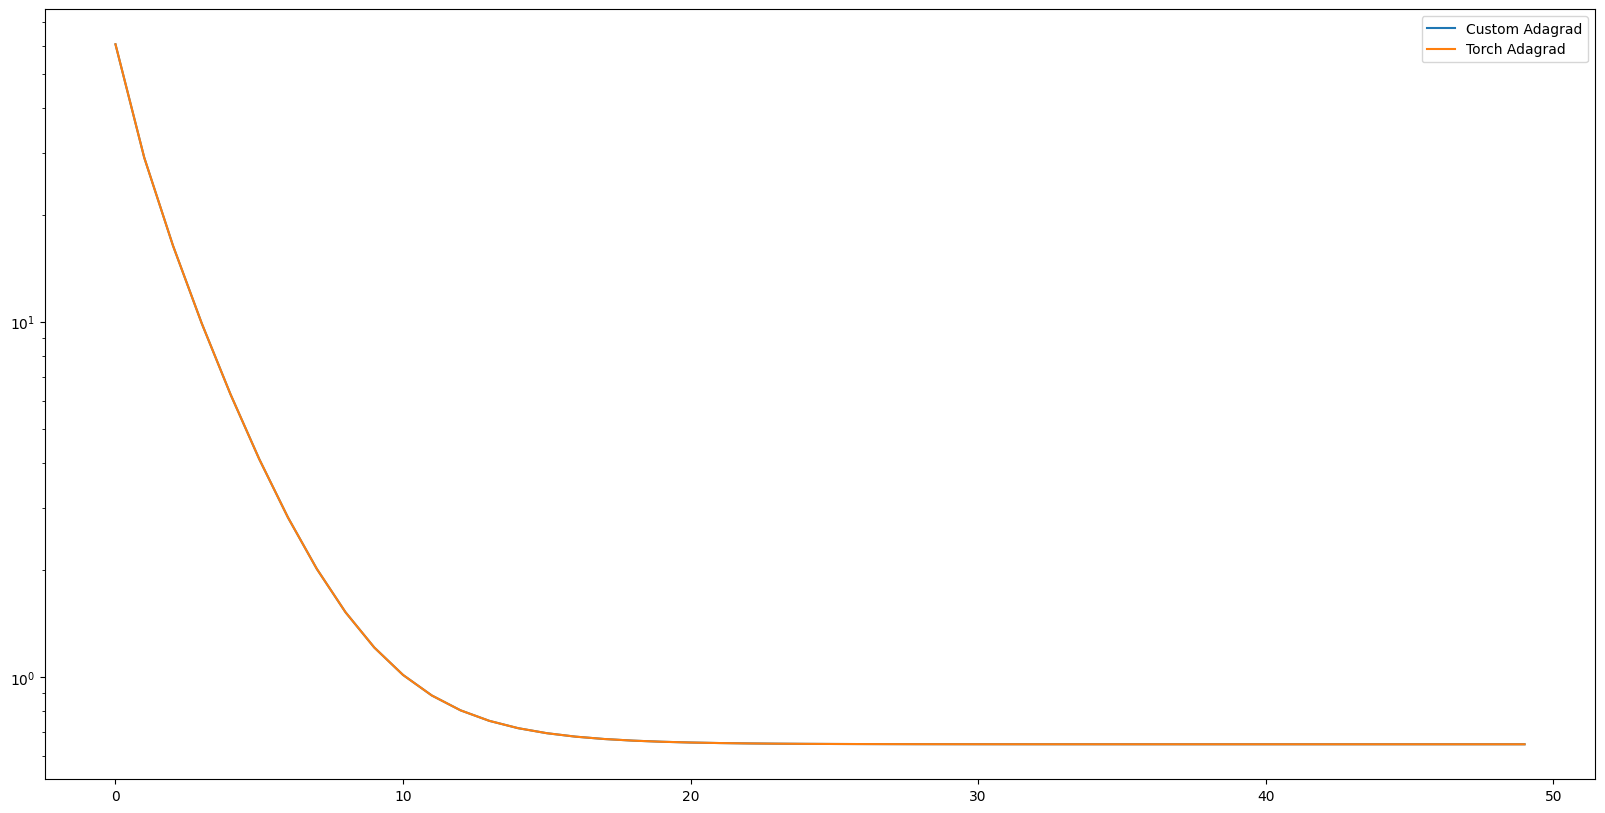

In [240]:
plt.plot(range(len(loss_list_adagrad)), loss_list_adagrad, label='Custom Adagrad')
plt.plot(range(len(loss_list_torch_adagrad)), loss_list_torch_adagrad, label='Torch Adagrad')
plt.yscale('log')
plt.legend()

In [241]:
tabl(['Custom Adagrad', 'Torch Adagrad'], start_point, [iterations_custom, iterations_torch], [points[-1], result],
     min_result)

       Method      Start point   Iterations                  Result                   Expected
0  Custom Adagrad  [-1.0, -1.0]      50      [0.5731430097781994, 1.207248230658615]  [0.5, 1]
1   Torch Adagrad  [-1.0, -1.0]      50      [0.5731475949287415, 1.207340121269226]  [0.5, 1]


## Вывод
В модификации Adagrad можно наблюдать удивительное сходство полученных результатов и затраченных итераций, это может быть связано с тем, что в этом алгоритме большую роль играет learning rate, из представленных модификаций именно она чаще всех страдает из-за неточного выбора шага. Алгоритм сам по себе прост и реализация его не может сильно отличаться, а learning rate выбран одинаково поэтому и результат вышел очень похожим.

In [242]:
def sgd_rmsprop(start, lr, max_epoch, batch=30, delta=1e-4, gamma=0.999, eps=1e-8):
    points = np.zeros((max_epoch, len(start)))
    s = np.array([0, 0])
    points[0] = start
    point = start.copy()
    loss_list = list()

    i = 1
    while i < max_epoch:
        global iterations_custom
        iterations_custom += 1

        yhat = point[1] + point[0] * w_0
        error = w_1 - yhat
        loss = (error ** 2).mean()
        loss_list.append(loss.data)

        g = grad(point, batch)
        s = gamma * s + (1 - gamma) * np.power(g, 2)
        point = point - lr / np.power(s + eps, 0.5) * g
        points[i] = point
        if stop(points[i], points[i - 1]):
            break
        i += 1

    return points[:i], loss_list

In [261]:
a = torch.tensor([start_point[0]], requires_grad=True)
b = torch.tensor([start_point[1]], requires_grad=True)
iterations_torch = 0

optimizer = optim.RMSprop([a, b], lr=0.02)

loss_list_torch_rmsprop = list()
grads_list = list()

for epoch in range(max_epoch):
    global iterations_torch
    iterations_torch += 1

    p1 = [b.item(), a.item()]

    yhat = a + b * w_0
    error = w_1 - yhat
    loss = (error ** 2).mean()
    loss_list_torch_rmsprop.append(loss.data)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    p2 = [b.item(), a.item()]

    if stop(np.array(p1), np.array(p2)):
        break

result = [b.item(), a.item()]

In [262]:
iterations_custom = 0
points, loss_list_rmsprop = sgd_rmsprop(start_point, 0.01, max_epoch=1000)

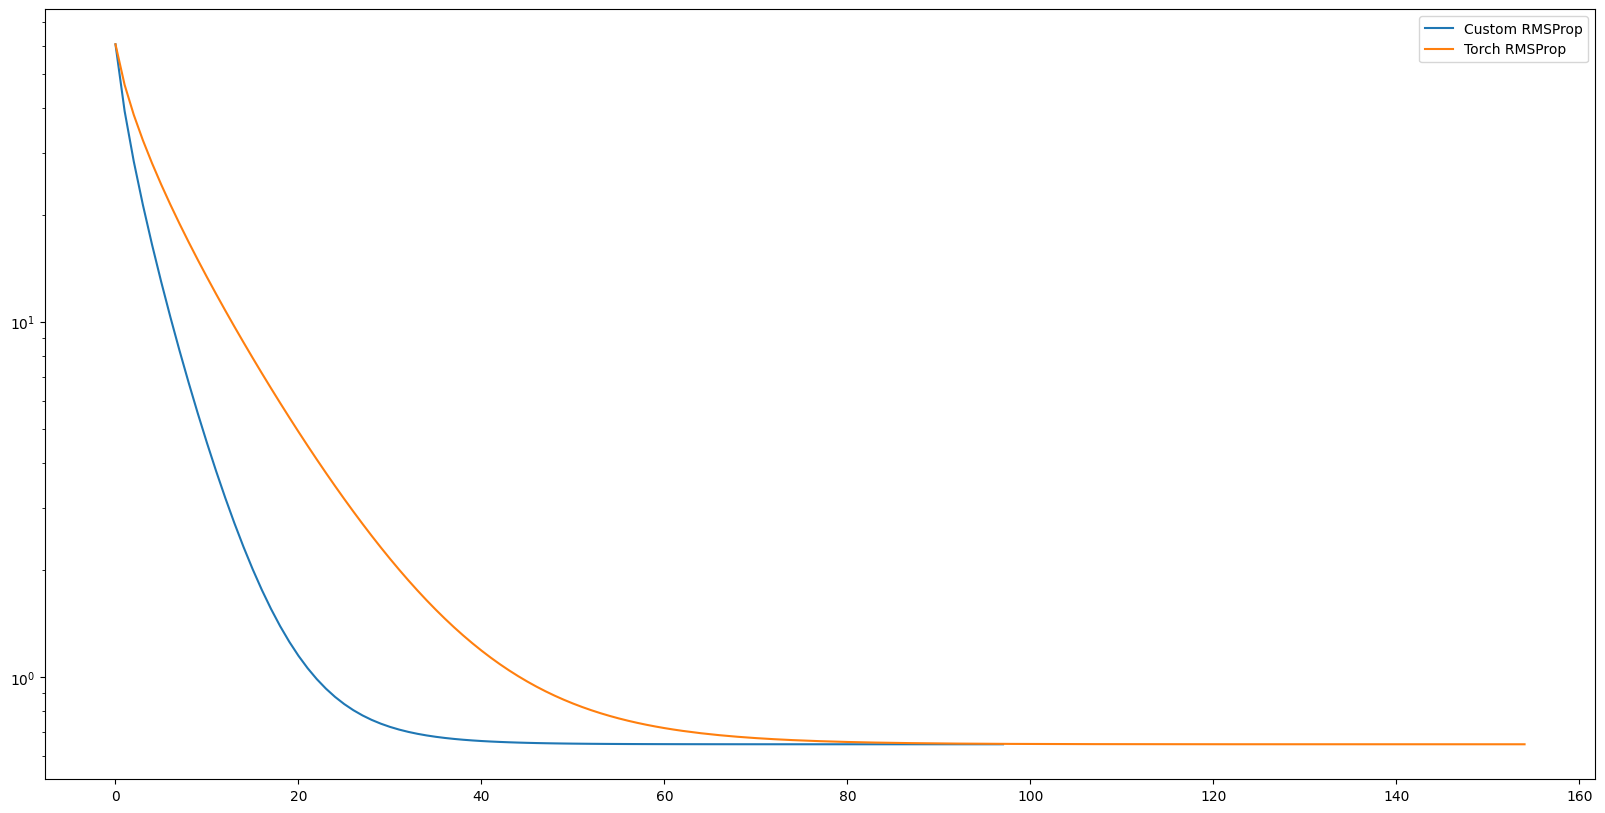

In [263]:
plt.plot(range(len(loss_list_rmsprop)), loss_list_rmsprop, label='Custom RMSProp')
plt.plot(range(len(loss_list_torch_rmsprop)), loss_list_torch_rmsprop, label='Torch RMSProp')
plt.yscale('log')
plt.legend()

In [264]:
tabl(['Custom RMSProp', 'Torch RMSProp'], start_point, [iterations_custom, iterations_torch], [points[-1], result],
     min_result)

       Method      Start point   Iterations                   Result                   Expected
0  Custom RMSProp  [-1.0, -1.0]       98      [0.5731099717081026, 1.206510965326887]  [0.5, 1]
1   Torch RMSProp  [-1.0, -1.0]      155     [0.5731180906295776, 1.2064971923828125]  [0.5, 1]


## Вывод
Это один из не многих случаев, где собственная реализация показывает себя лучше библиотечной, так как при одинаковой точности найденного минимума, реализация из PyTorch сходилась в полтора раза медленнее. Данный эффект связан прежде всего с реализацией, Если посмотреть на псевдокод этой модификации на сайте PyTorch, то сложно заметить некоторые параметры, которые не использовались в нашем методе, эти дополнительные элементы помогают алгоритму показывать хороший результат даже при неудачном подборе констант шага и т.д.

In [265]:
def sgd_adam(start, lr, max_epoch, batch=30, delta=1e-3, gamma_1=0.9, gamma_2=0.999, eps=1e-8):
    points = np.zeros((max_epoch, len(start)))
    v_prev = np.array([0, 0])
    s_prev = np.array([0, 0])
    points[0] = start
    point = start.copy()
    loss_list = list()

    i = 1
    while i < max_epoch:
        global iterations_custom
        iterations_custom += 1

        yhat = point[1] + point[0] * w_0
        error = w_1 - yhat
        loss = (error ** 2).mean()
        loss_list.append(loss.data)

        g = grad(point, batch)
        v_current = gamma_1 * v_prev + (1 - gamma_1) * g
        s_current = gamma_2 * s_prev + (1 - gamma_2) * np.power(g, 2)
        v_normalize = v_current / (1 - np.power(gamma_1, i))
        s_normalize = s_current / (1 - np.power(gamma_2, i))
        point = point - lr * v_normalize / np.power(s_normalize + eps, 0.5)
        v_prev = v_current
        s_prev = s_current
        points[i] = point
        if stop(points[i], points[i - 1]):
            break
        i += 1

    return points[:i], loss_list

In [266]:
a = torch.tensor([start_point[0]], requires_grad=True)
b = torch.tensor([start_point[1]], requires_grad=True)
iterations_torch = 0

optimizer = optim.Adam([a, b], lr=0.1)

loss_list_torch_adam = list()
grads_list = list()

for epoch in range(max_epoch):
    global iterations_torch
    iterations_torch += 1

    p1 = [b.item(), a.item()]

    yhat = a + b * w_0
    error = w_1 - yhat
    loss = (error ** 2).mean()
    loss_list_torch_adam.append(loss.data)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    p2 = [b.item(), a.item()]

    if stop(np.array(p1), np.array(p2)):
        break

result = [b.item(), a.item()]

In [267]:
iterations_custom = 0
points, loss_list_adam = sgd_adam(start_point, 0.1, max_epoch=1000)

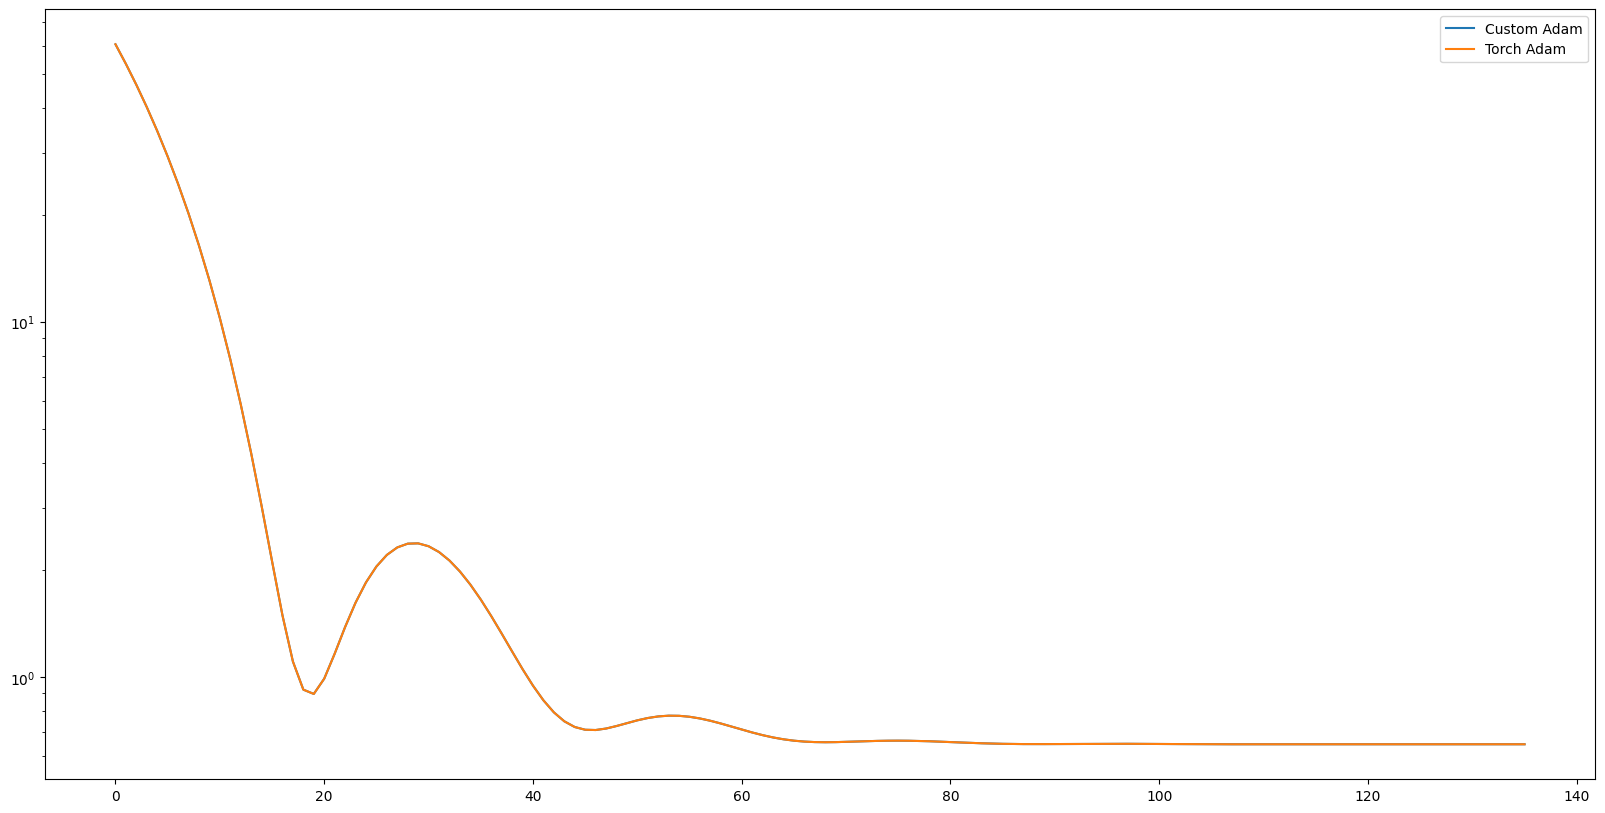

In [268]:
plt.plot(range(len(loss_list_adam)), loss_list_adam, label='Custom Adam')
plt.plot(range(len(loss_list_torch_adam)), loss_list_torch_adam, label='Torch Adam')
plt.yscale('log')
plt.legend()

In [269]:
tabl(['Custom Adam', 'Torch Adam'], start_point, [iterations_custom, iterations_torch], [points[-1], result],
     min_result)

     Method     Start point   Iterations                  Result                   Expected
0  Custom Adam  [-1.0, -1.0]      136     [0.5720893190313846, 1.211113135744633]  [0.5, 1]
1   Torch Adam  [-1.0, -1.0]      136     [0.5721338987350464, 1.211153507232666]  [0.5, 1]


## Вывод
Adam показал крайнее точное сходство и в плане ответа и в плане скорости сходимости алгоритма.